<a href="https://colab.research.google.com/github/nickelodeon20/Test-Model-Performances/blob/main/ATCNet/ATCNet_BCI_IV2a_data_TrainValidTestSPLIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Authors: Lukas Gemein
#          Hubert Banville
#          Simon Brandt
#          Daniel Wilson
#
# License: BSD (3-clause)
!pip install braindecode # Install braindecode package
from braindecode.datasets import MOABBDataset

In [6]:
!pip install moabb

In [7]:
subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|██████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 125GB/s]
SHA256 hash of downloaded file: 7e731ee8b681d5da6ecb11ae1d4e64b1653c7f15aad5d6b7620b25ce53141e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 42.3M/42.3M [

In [8]:
!pip install --upgrade numpy

from numpy import multiply

from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

# Define a named function for volt-to-microvolt conversion
def convert_to_microvolts(data, factor=factor):
    return multiply(data, factor)

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(convert_to_microvolts,  apply_on_array=True),  # Convert from V to uV using the named function
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 156.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moabb 1.2.0 requires numpy<2.0,>=1.22, but you have numpy 2.2.5 which is incompatible.


In [11]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np

In [30]:
from braindecode.datasets import BaseConcatDataset
import random

# Debugging function to check shapes of datasets
def get_baseconcatdataset_shape(dataset):
    """
    Gets the shape of a BaseConcatDataset.

    Args:
        dataset: The BaseConcatDataset object.

    Returns:
        A tuple representing the shape of the dataset: (num_examples, num_channels, num_timepoints).
    """

    num_examples = len(dataset)

    # If dataset is empty, return (num_examples, 0, 0)
    if not dataset.datasets:
        return (num_examples, 0, 0)

    # Assume all datasets have the same shape, access shape of the first example
    # of the first dataset
    num_channels = dataset.datasets[0][0][0].shape[0]
    num_timepoints = dataset.datasets[0][0][0].shape[1]

    return (num_examples, num_channels, num_timepoints)



# Split the dataset into training and test set.

splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
test_set = splitted['1test']  # Session evaluation
print("Windows_dataset before split: " + str(get_baseconcatdataset_shape(windows_dataset)))
print("------------------------------")
print("Test_set (not involved in split): " + str(get_baseconcatdataset_shape(test_set)))
print("------------------------------")
print("Train_set before split: " + str(get_baseconcatdataset_shape(train_set)) + "\n")



# Split training into training and validation sets

random.seed(42)

# Get the list of datasets within valid_set
train_set_datasets = train_set.datasets

# Create new split indices within the
n_valid_trials = len(train_set_datasets)
all_ids = list(range(n_valid_trials))
random.shuffle(all_ids)

train_set_ids = list(range(0, int(0.8 * n_valid_trials)))  # First half of valid_set
valid_set_ids = list(range(int(0.8 * n_valid_trials), n_valid_trials))  # Second half of valid_set

print("Train Set ids: " + str(train_set_ids))
print("------------------------------")
print("Valid Set ids: " + str(valid_set_ids) + "\n")

# Create subsets of valid_set based on indices
train_set_subset = BaseConcatDataset([train_set_datasets[i] for i in train_set_ids])
valid_set_subset = BaseConcatDataset([train_set_datasets[i] for i in valid_set_ids])



# Update the valid_set with the new subsets
train_set = train_set_subset
valid_set = valid_set_subset

print("Windows_dataset after split: " + str(get_baseconcatdataset_shape(windows_dataset)))
print("------------------------------")
print("Test_set after split (not involved in split): " + str(get_baseconcatdataset_shape(test_set)))
print("------------------------------")
print("Valid_set after split (20%): " + str(get_baseconcatdataset_shape(valid_set)))
print("------------------------------")
print("Train_set after split (80%): " + str(get_baseconcatdataset_shape(train_set)))


Windows_dataset before split: (576, 22, 1125)
------------------------------
Test_set (not involved in split): (288, 22, 1125)
------------------------------
Train_set before split: (288, 22, 1125)

Train Set ids: [0, 1, 2, 3]
------------------------------
Valid Set ids: [4, 5]

Windows_dataset after split: (576, 22, 1125)
------------------------------
Test_set after split (not involved in split): (288, 22, 1125)
------------------------------
Valid_set after split (20%): (96, 22, 1125)
------------------------------
Train_set after split (80%): (192, 22, 1125)


In [31]:
import torch

from braindecode.models import ATCNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
   torch.backends.cudnn.benchmark = True

n_classes = 4

def create_atcnet_model(train_set, n_classes=n_classes, seed=20200220):
    """Creates and initializes an ATCNet model.

    Args:
        train_set: The training dataset.
        n_classes: The number of classes.
        seed: The random seed.

    Returns:
        The ATCNet model.
    """


    set_random_seeds(seed=seed, cuda=cuda)

    # Extract number of channels and time steps from dataset
    n_chans = train_set[0][0].shape[0]

    # Create the model
    model = ATCNet(n_chans, n_classes)

    # Send model to GPU if available
    if cuda:
        model = model.cuda()

    return model

# Example usage:
model = create_atcnet_model(train_set)
print(model)

Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Kernel Shape
ATCNet (ATCNet)                                         [1, 22, 1125]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1                            [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-2                           [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─_ConvBlock (conv_block): 1-3                          [1, 1, 1125, 22]          [1, 32, 20, 1]            --                        --
│    └─Conv2d (conv1): 2-1                              [1, 1, 1125, 22]          [1, 16, 1125, 22]         1,024                     [64, 1]
│    └─BatchNorm2d (bn1): 2-2                           [1, 16, 1125, 22]         [1, 16, 1125, 22]         32                        --
│    └─Conv2d (conv2): 2-3

/usr/local/lib/python3.11/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [32]:
from skorch.callbacks import LRScheduler, EpochScoring, EarlyStopping
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# We found these values to be good for the shallow network:
#lr = 0.0625 * 0.01
#weight_decay = 0

# ATCNet testing (based off ATCNet paper)
lr = 0.0009
weight_decay = 0.0001

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 1000
classes = ['left_hand', 'right_hand', 'feet', 'tongue']

early_stopping_train = EarlyStopping(patience=300, monitor="train_loss", lower_is_better=True)
early_stopping_valid = EarlyStopping(patience=300, monitor="valid_loss", lower_is_better=True)

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ('train_acc', EpochScoring(scoring='accuracy', on_train=True, name='train_acc')),
               ('train_f1', EpochScoring(scoring='f1_macro', on_train=True, name='train_f1')),
                ('precision', EpochScoring(scoring='precision_macro', on_train=True, name='train_precision')),
                ('recall', EpochScoring(scoring='recall_macro', on_train=True, name='train_recall')),  # Add the F1 score callback
        ("early_stopping_train", early_stopping_train),
        ("early_stopping_valid", early_stopping_valid),

    ],
    device=device,
    classes=classes,
)
# Model training for the specified number of epochs. `y` is None as it is
# already supplied in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_acc    train_f1    train_loss    train_precision    train_recall    valid_acc    valid_loss      lr     dur
-------  -----------  ----------  ------------  -----------------  --------------  -----------  ------------  ------  ------
      1       0.2552      0.2411        1.4531             0.2425          0.2552       0.2500        1.4143  0.0009  0.8868
      2       0.3125      0.3047        1.3973             0.3084          0.3125       0.2500        1.4109  0.0009  0.8983
      3       0.2917      0.2897        1.4011             0.2967          0.2917       0.2500        1.4079  0.0009  0.8904
      4       0.2812      0.2761        1.4184             0.2772          0.2812       0.2500        1.4056  0.0009  0.9023
      5       0.2969      0.2960        1.3938             0.2966          0.2969       0.2500        1.3980  0.0009  0.8914
      6       0.3229      0.3144        1.3559             0.3114          0.3229       0.2708        1.3868  0.0009  0.8988


Max Valid Acc. (after epoch 70 until end): 0.78125
--------------------------------------------
Min Valid Acc. (after epoch 70 until end): 0.6458333333333334
--------------------------------------------
Std. Dev. of Valid Acc. (after epoch 70 until end): 0.027468416206415852
--------------------------------------------
Mean Valid Acc. (after epoch 70 until end): 0.7195833333333334




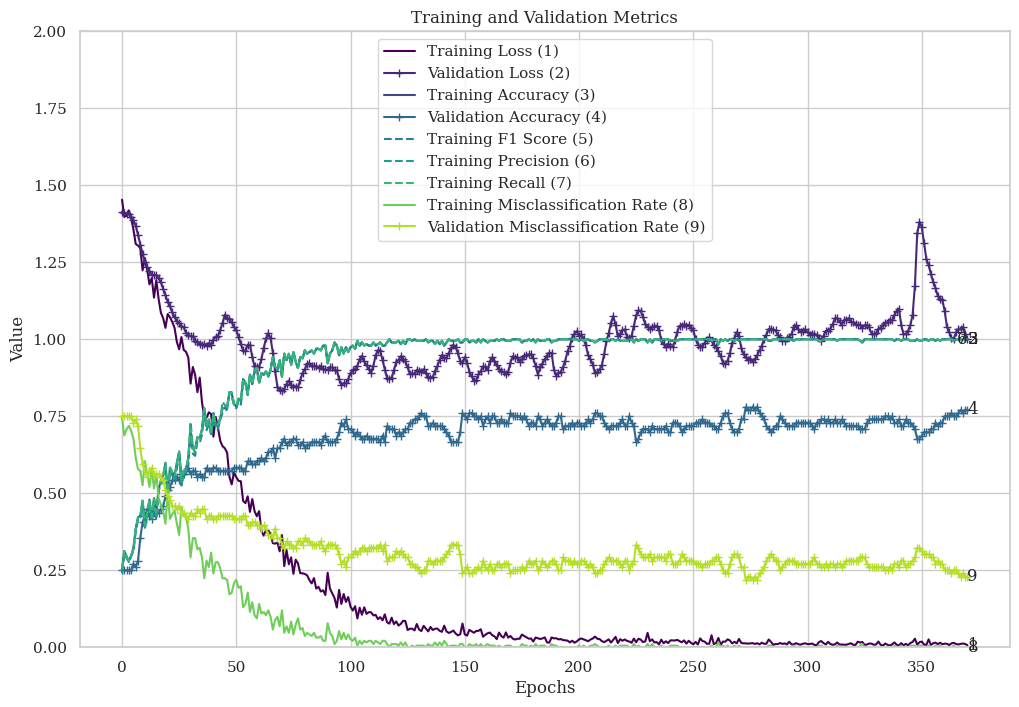

In [33]:
import matplotlib.pyplot as plt
from numpy import array, arange, max, min, std, mean
from matplotlib import cm


# Estimate of when model stops learning
end_epoch = len(clf.history_)-1  # Get the last epoch
#********CHANGE BASED ON patience (i.e = 300)
start_epoch = end_epoch - 300
valid_loss = clf.history_[start_epoch:end_epoch, 'valid_acc']  # Slice the array

# Calculate statistics
max_valid_loss = max(valid_loss)
min_valid_loss = min(valid_loss)
std_dev_valid_loss = std(valid_loss)
mean_valid_loss = mean(valid_loss)

# Print the results
print(f"Max Valid Acc. (after epoch {start_epoch} until end): {max_valid_loss}")
print("--------------------------------------------")
print(f"Min Valid Acc. (after epoch {start_epoch} until end): {min_valid_loss}")
print("--------------------------------------------")
print(f"Std. Dev. of Valid Acc. (after epoch {start_epoch} until end): {std_dev_valid_loss}")
print("--------------------------------------------")
print(f"Mean Valid Acc. (after epoch {start_epoch} until end): {mean_valid_loss}\n\n")



# Extract the values for the metrics
train_loss = clf.history_[:, 'train_loss']
valid_loss = clf.history_[:, 'valid_loss']
train_acc = clf.history_[:, 'train_acc']
valid_acc = clf.history_[:, 'valid_acc']
train_f1 = clf.history_[:, 'train_f1']
precision = clf.history_[:, 'train_precision']
recall = clf.history_[:, 'train_recall']

# Calculate misclassification rates
train_misclass = (100 - 100 * array(train_acc))/100
valid_misclass = (100 - 100 * array(valid_acc))/100

# Get a colormap
cmap = plt.colormaps['viridis']

# Create the plot
epochs = arange(len(train_loss))

plt.figure(figsize=(12, 8))

metrics = [train_loss, valid_loss, train_acc, valid_acc, train_f1, precision, recall, train_misclass, valid_misclass]
labels = ['Training Loss (1)', 'Validation Loss (2)', 'Training Accuracy (3)', 'Validation Accuracy (4)', 'Training F1 Score (5)',
          'Training Precision (6)', 'Training Recall (7)', 'Training Misclassification Rate (8)', 'Validation Misclassification Rate (9)']
linestyles = ['-', '-', '-', '-', '--', '--', '--', '-', '-'] # Add your linestyles here
markers = ['', '+', '', '+', '', '', '', '', '+'] # Add your markers here

# Normalization for colormap indexing
norm = plt.Normalize(0, len(metrics))

for i, (metric, label, linestyle, marker) in enumerate(zip(metrics, labels, linestyles, markers)):
    plt.plot(epochs, metric, label=label, linestyle=linestyle, marker=marker, color=cmap(norm(i)))


plt.text(epochs[-1], train_loss[-1], '1', ha='left', va='center')
plt.text(epochs[-1], valid_loss[-1], '2', ha='left', va='center')
plt.text(epochs[-1], train_acc[-1], '3', ha='left', va='center')
plt.text(epochs[-1], valid_acc[-1], '4', ha='left', va='center')
plt.text(epochs[-1], train_f1[-1], '5', ha='left', va='center')
plt.text(epochs[-1], precision[-1], '6', ha='right', va='center')
plt.text(epochs[-1], recall[-1], '7', ha='right', va='center')
plt.text(epochs[-1], train_misclass[-1], '8', ha='left', va='center')
plt.text(epochs[-1], valid_misclass[-1], '9', ha='left', va='center')


plt.ylim(0, 2)

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True, )
plt.show()

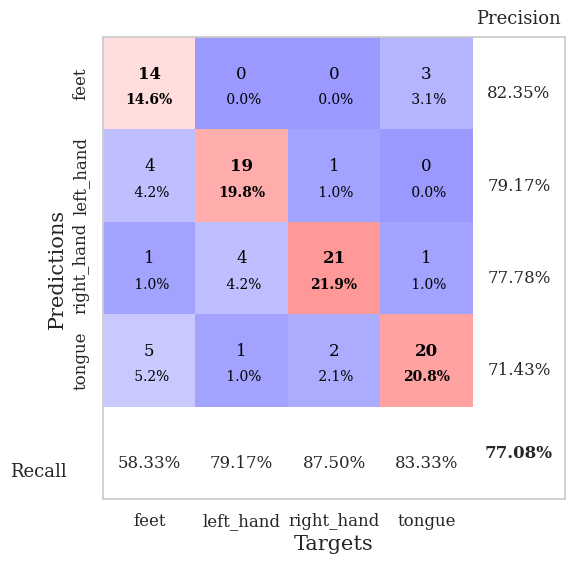

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set_subset.get_metadata().target
y_pred = clf.predict(valid_set_subset)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)


# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = windows_dataset.datasets[0].window_kwargs[0][1]['mapping']
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels, figsize=(6, 6));

 Test Accuracy: 0.7569
Test Precision (macro): 0.7655
Test Recall (macro): 0.7569
Test F1 Score (macro): 0.7440



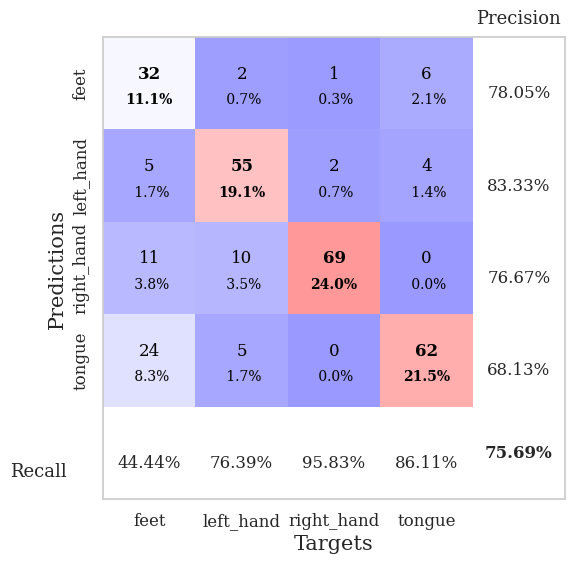

In [35]:
# generate confusion matrices
# get the targets
y_true_test = test_set.get_metadata().target
y_pred_test = clf.predict(test_set)

# Calculate accuracy
accuracy = accuracy_score(y_true_test, y_pred_test)

# Calculate precision (macro-averaged)
precision = precision_score(y_true_test, y_pred_test, average='macro')

# Calculate recall (macro-averaged)
recall = recall_score(y_true_test, y_pred_test, average='macro')

# Calculate F1 score (macro-averaged)
f1 = f1_score(y_true_test, y_pred_test, average='macro')

# Print the metrics
print(f" Test Accuracy: {accuracy:.4f}")
print(f"Test Precision (macro): {precision:.4f}")
print(f"Test Recall (macro): {recall:.4f}")
print(f"Test F1 Score (macro): {f1:.4f}\n")

# generating confusion matrix
confusion_mat_test = confusion_matrix(y_true_test, y_pred_test)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = windows_dataset.datasets[0].window_kwargs[0][1]['mapping']
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat_test, class_names=labels, figsize=(6, 6));